In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.metrics import MeanSquaredError
import numpy as np

# Assuming data is loaded similar to arima_1.py
data = pd.read_csv('C:/Users/Wilson/Desktop/TB2/Dataminiproject/Dataset/UoB_Set01_2025-01-02tapes.csv', header=None, names=['seconds', 'transaction_price', 'number_of_transactions'])
data['timestamp'] = pd.to_timedelta(data['seconds'], unit='s') + pd.Timestamp('2025-01-02 00:00')
data.set_index(keys='timestamp', inplace=True)
resampled_data = data['transaction_price'].resample('1S').mean()
resampled_data_ffill = resampled_data.fillna(method='ffill').dropna()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(resampled_data_ffill.values.reshape(-1,1))

C:\Users\Wilson\AppData\Local\Temp\ipykernel_29252\1802603839.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


C:\Users\Wilson\AppData\Local\Temp\ipykernel_29252\1802603839.py:12: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled_data = data['transaction_price'].resample('1S').mean()
C:\Users\Wilson\AppData\Local\Temp\ipykernel_29252\1802603839.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  resampled_data_ffill = resampled_data.fillna(method='ffill').dropna()


In [2]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1  # Based on previous timestep
X, Y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))


In [3]:
# Split data into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=128, verbose=2)





Epoch 1/50

192/192 - 1s - loss: 0.2926 - 1s/epoch - 6ms/step
Epoch 2/50
192/192 - 0s - loss: 0.0561 - 176ms/epoch - 919us/step
Epoch 3/50
192/192 - 0s - loss: 0.0281 - 177ms/epoch - 922us/step
Epoch 4/50
192/192 - 0s - loss: 0.0226 - 175ms/epoch - 909us/step
Epoch 5/50
192/192 - 0s - loss: 0.0169 - 174ms/epoch - 906us/step
Epoch 6/50
192/192 - 0s - loss: 0.0115 - 174ms/epoch - 908us/step
Epoch 7/50
192/192 - 0s - loss: 0.0071 - 173ms/epoch - 899us/step
Epoch 8/50
192/192 - 0s - loss: 0.0040 - 174ms/epoch - 905us/step
Epoch 9/50
192/192 - 0s - loss: 0.0024 - 171ms/epoch - 890us/step
Epoch 10/50
192/192 - 0s - loss: 0.0017 - 174ms/epoch - 905us/step
Epoch 11/50
192/192 - 0s - loss: 0.0015 - 172ms/epoch - 896us/step
Epoch 12/50
192/192 - 0s - loss: 0.0015 - 177ms/epoch - 922us/step
Epoch 13/50
192/192 - 0s - loss: 0.0015 - 173ms/epoch - 904us/step
Epoch 14/50
192/192 - 0s - loss: 0.0015 - 174ms/epoch - 908us/step
Epoch 15/50
192/192 - 0s - loss: 0.0015 - 177ms/epoch - 924us/step
Epoch 

In [4]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


192/192 [==============================] - 0s 629us/step


Train Score: 2.28 RMSE
Test Score: 2.27 RMSE


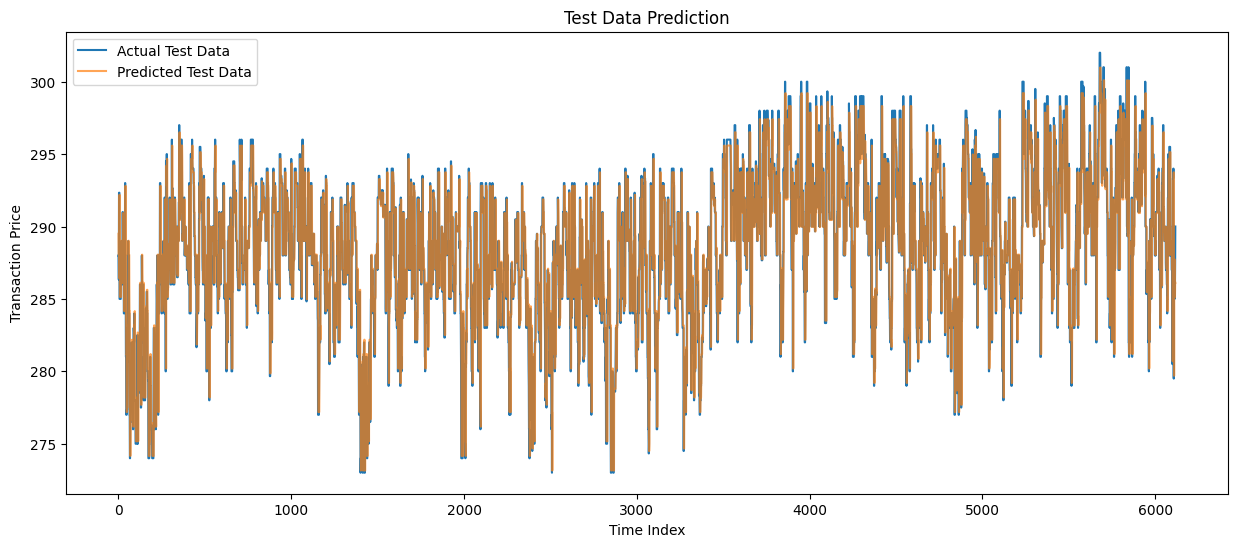

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE for training and test sets
trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print(f'Train Score: {trainScore:.2f} RMSE')
testScore = sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print(f'Test Score: {testScore:.2f} RMSE')

# Calculate indices for test data in the original dataset
test_data_start_index = len(scaled_data) - test_size

# Prepare test data from original dataset for plotting
original_test_data = scaler.inverse_transform(scaled_data[test_data_start_index:])

# Prepare test predictions for plotting
# Note: The testPredict has already been scaled back to the original scale

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(original_test_data, label='Actual Test Data')
plt.plot(testPredict, label='Predicted Test Data', alpha=0.7)
plt.title('Test Data Prediction')
plt.xlabel('Time Index')
plt.ylabel('Transaction Price')
plt.legend()
plt.show()


In [8]:
# Generate timestamps for the test dataset
# Since we have used a look_back of 1, the first prediction corresponds to the second timestamp in the test dataset
test_timestamps = resampled_data_ffill.index[train_size + look_back : len(resampled_data_ffill) - 1]

# Create a DataFrame for the test predictions with corresponding timestamps
test_predictions_df = pd.DataFrame(data=testPredict, index=test_timestamps, columns=['transaction_price'])

# Reset index to convert the timestamp index into a column
test_predictions_df.reset_index(inplace=True)

# Rename the index column to 'timestamp' to match the required output format
test_predictions_df.rename(columns={'index': 'timestamp'}, inplace=True)

# Export the DataFrame to a CSV file
test_predictions_df.to_csv('C:/Users/Wilson/Desktop/TB2/Dataminiproject/Results/predictions.csv', index=False)

print("CSV file has been exported.")



CSV file has been exported.
